In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn visualization library
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


**Flags that help control the current of the code (may not be used, just my style homie)**

In [2]:
# Flags
age_bins = True   # Convert Age integer column by grouping passengers into categories

**Lets import some sad data and see if the movie is true**

In [3]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")

In [4]:
df.shape

(891, 12)

**891 samples, 12 features**

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Lets prepare the robots meal

**Check if any values are missing**

In [6]:
df.isnull().sum().sort_values(ascending=False)[:]

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [7]:
df.isna().sum().sort_values(ascending=False)[:]

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [8]:
print("Proportion of missing values")
missing_values_count = df.isna().sum()*100/df.shape[0]
missing_values_count

Proportion of missing values


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

**Some missing values, lets take care of this. Firt lets look at how many values each features have**

In [9]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

**For the age, lets create a transformer to fill in the missing values with the mean**

In [11]:
# Treat age as a category or pure integer
if age_bins:
    cats = ['Child', 'Young Adult', 'Adult', 'Elderly']
    bins = [0, 16, 25, 50, 100]
    age_in_bins = pd.cut(df.Age, bins, labels=cats)
    df['Age'] = age_in_bins
    df['Age'] = df['Age'].astype('category')
    age_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
else:
    age_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])


**The missing Embarked is insignificant because they're very few of em and I dont think the feature is siginificant anyway. Just go with the most frequent value**

In [12]:
emb_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

**The Cabin feature is different, ~77% of the data is missing and at first thought I think they're could be a connection to survivability**

In [13]:
df.drop(columns = ['Cabin'], inplace = True)

**Lets set some transformers to preprocess some data using on hot and standardization**

In [14]:
onehot_feats = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
stand_feats  = ['Fare']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

**Last 2 features we need to process are the Name and Ticket columns**

**Lets take just the first name of all passengers and make a new column in the dataframe**

In [15]:
# Convert Name to a string
df['Name'] = df['Name'].astype('str')
# Split up name into 3 parts
whole_name = df["Name"].str.split(" ", n = 3, expand = True)

In [16]:
# Add name parts to the data frame
df["First Name"] = whole_name[2]
df["Title"] = whole_name[1]
df["Last Name"] = whole_name[0]
# Strip the comma from the last name
df['Last Name'] = df['Last Name'].map(lambda x: x.rstrip(','))
# Drop the original Name column
df.drop(columns = ['Name'], inplace = True)
df.sample(20)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,First Name,Title,Last Name
145,146,0,2,male,Young Adult,1,1,C.A. 33112,36.7500,S,Joseph,Mr.,Nicholls
824,825,0,3,male,Child,4,1,3101295,39.6875,S,Urho,Master.,Panula
531,532,0,3,male,NaN,0,0,2641,7.2292,C,Nakli,Mr.,Toufik
112,113,0,3,male,Young Adult,0,0,324669,8.0500,S,David,Mr.,Barton
865,866,1,2,female,Adult,0,0,236852,13.0000,S,(Karolina),Mrs.,Bystrom
171,172,0,3,male,Child,4,1,382652,29.1250,Q,Arthur,Master.,Rice
106,107,1,3,female,Young Adult,0,0,343120,7.6500,S,Anna,Miss.,Salkjelsvik
359,360,1,3,female,NaN,0,0,330980,7.8792,Q,Helen,Miss.,Mockler
890,891,0,3,male,Adult,0,0,370376,7.7500,Q,Patrick,Mr.,Dooley
134,135,0,2,male,Young Adult,0,0,C.A. 29178,13.0000,S,Samuel,Mr.,Sobey


**Lets take a look at how many possibilities these new features have**

In [17]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Sex              2
Age              4
SibSp            7
Parch            7
Ticket         681
Fare           248
Embarked         3
First Name     435
Title           31
Last Name      661
dtype: int64

**Add the name parts to the list of one hot encoders**

In [18]:
onehot_feats.extend(['First Name', 'Last Name', 'Title'])

**The Ticket feature is the last to be preprocessed**

In [19]:
# Convert Name to a string
df['Ticket'] = df['Ticket'].astype('str')
# Split up ticket feature into 2 parts
ticket = df["Ticket"].str.split(" ", n = 1, expand = True)
# Rename the columns to the string part and number part
ticket.columns = ['Char', 'Number']
# Refine the uneven data a bit
for ind in ticket.index:
     if ticket['Number'][ind] is None:
            ticket['Number'][ind] = ticket['Char'][ind]
            ticket['Char'][ind] = None
            
     if ' ' in ticket['Number'][ind]:
        ticket_ext = ticket["Number"].str.split(" ", n = 1, expand = True)
        ticket_ext.columns = ['Char_ext', 'Number_ext']
        ticket['Number'][ind] = ticket_ext['Number_ext'][ind]
        
ticket.sample(7)

,Char,Number
307,PC,17758
74,None,1601
270,None,113798
656,None,349223
577,None,13507
413,None,239853
775,None,347078


In [20]:
# Check the number of unique values for each feature
ticket.nunique()

Char       42
Number    679
dtype: int64

In [21]:
# Check how many values are missing
ticket.isna().sum().sort_values(ascending=False)[:]

Char      665
Number      0
dtype: int64

**Lets drop the character part of the ticket since they're isnt a lot of data and add the number portion to be standardized**

In [22]:
# Drop 'Char' column
ticket.drop(columns = ['Char'], inplace = True)
# We have a value "Line" we need to get rid of from the ticket number
for ind in ticket.index:
     if ticket['Number'][ind] == 'LINE':
            ticket['Number'][ind] = None
            
# Create a transformer to fill in the mean for the ticket values = None
ticket_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Replace ticket in main data frame with the one just created
df["Ticket"] = ticket

# Convert "Ticket" to numeric values to be processed
df["Ticket"] = pd.to_numeric(df["Ticket"])

# Add the "Ticket" to the list to be standardize
df.sample(7)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,First Name,Title,Last Name
266,267,0,3,male,Child,4,1,3101295.0,39.6875,S,Ernesti,Mr.,Panula
663,664,0,3,male,Adult,0,0,349210.0,7.4958,S,Peju,Mr.,Coleff
451,452,0,3,male,NaN,1,0,65303.0,19.9667,S,Ingvald,Mr.,Hagland
291,292,1,1,female,Young Adult,1,0,11967.0,91.0792,C,Dickinson,Mrs.,Bishop
815,816,0,1,male,NaN,0,0,112058.0,0.0000,S,Richard,Mr.,Fry
710,711,1,1,female,Young Adult,0,0,17482.0,49.5042,C,Berthe,Mlle.,Mayne
343,344,0,2,male,Young Adult,0,0,244361.0,13.0000,S,Charles,Mr.,Sedgwick


In [23]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Sex              object
Age            category
SibSp             int64
Parch             int64
Ticket          float64
Fare            float64
Embarked         object
First Name       object
Title            object
Last Name        object
dtype: object

In [24]:
# Convert the object features to categories so it plays nice with the onehotencoder
for i in ['Sex', 'Embarked', 'First Name', 'Title', 'Last Name']:
    df[i] = df[i].astype('category')

In [25]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Sex            category
Age            category
SibSp             int64
Parch             int64
Ticket          float64
Fare            float64
Embarked       category
First Name     category
Title          category
Last Name      category
dtype: object

# Feed the Robot!

**Breakdown the data frame to training and test set**

In [26]:
# Breakdown the data frame into attributes and label (Survived)
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Preprocess the data**

In [27]:
# Data cleaning and transforming
df['Embarked'].fillna(df.mode().iloc[0])

preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_transformer, ["Age"]),
        ('tic', ticket_transformer, ["Ticket"]),
        ('cat', categorical_transformer, onehot_feats),  
        ('num', numeric_transformer, stand_feats)])

**Set up the classifiers we will run**

In [28]:
# Run multiple models and compare
classifiers = [
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    ]

**Let it rip**

In [29]:
print("** Following results reflect classifier models **")
classif_list = []
acc_list = []
incorrect_mtrx = []
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    
    # Predict the test labels
    preds = pipe.predict(X_test)
    
    # Keep wrong prediction data
    truth_list = y_test.values.tolist()
    incorrect = []
    for j in range(0,len(preds)):
        if preds[j] != truth_list[j]:
            incorrect.append(j)        # I should probably do this by passengerid, not by index
    
    incorrect_mtrx.append(incorrect)
    # Calculate the accuracy and cofussion matrix
    acc_score = accuracy_score(y_test, preds)
    conf_matrix = confusion_matrix(y_test, preds)
    
    # Calculate how many preidctions were right and wrong
    n_labels_right = accuracy_score(y_test, preds, normalize=False)
    n_labels_total = y_test.size
      
    # Print details of classifiers, accuracy and cofussion matrix
    print("-------------------------------------------")
    print(classifier)
    print("Accuracy: ", acc_score*100)
    print("Predictions correct = ", n_labels_right)
    print("Predictions wrong   = ", n_labels_total - n_labels_right)
    print("Confussion matrix = \n", conf_matrix)
    
    # Put classifier and accuracy in list to extract the best at the end
    classif_list.append(classifier)
    acc_list.append(acc_score*100)

** Following results reflect classifier models **
-------------------------------------------
SVC(C=0.025, probability=True)
Accuracy:  60.0896860986547
Predictions correct =  134
Predictions wrong   =  89
Confussion matrix = 
 [[134   0]
 [ 89   0]]
-------------------------------------------
DecisionTreeClassifier()
Accuracy:  84.75336322869956
Predictions correct =  189
Predictions wrong   =  34
Confussion matrix = 
 [[122  12]
 [ 22  67]]
-------------------------------------------
RandomForestClassifier()
Accuracy:  81.61434977578476
Predictions correct =  182
Predictions wrong   =  41
Confussion matrix = 
 [[120  14]
 [ 27  62]]
-------------------------------------------
AdaBoostClassifier()
Accuracy:  79.82062780269058
Predictions correct =  178
Predictions wrong   =  45
Confussion matrix = 
 [[111  23]
 [ 22  67]]
-------------------------------------------
GradientBoostingClassifier()
Accuracy:  83.40807174887892
Predictions correct =  186
Predictions wrong   =  37
Confussion

# Cool! Got some good predictor models

**(In progress) Some extra credit here. Feel free to move along**

**Lets take a look at the samples we predicted wrong**

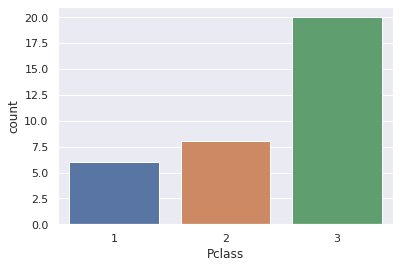

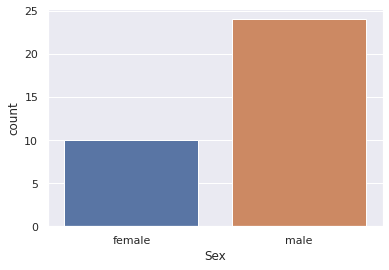

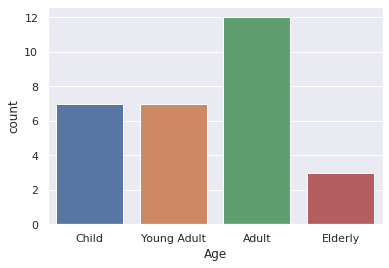

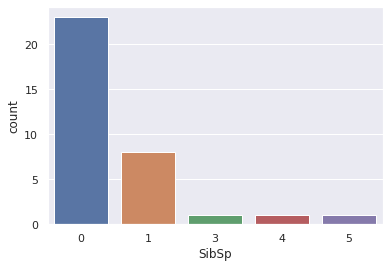

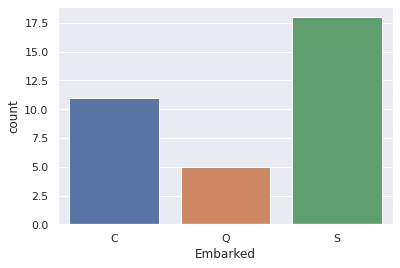

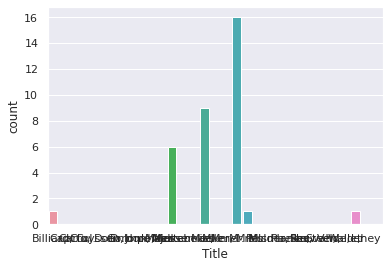

In [30]:
# Create a sub dataframe with just the sample we incorrectly labeled
wrong_indx_list = incorrect_mtrx[1]
wrong_df = df.iloc[wrong_indx_list]
cat_feats = ["Pclass", "Sex", "Age", "SibSp", "Embarked", "Title"]
for feat in cat_feats:
    sns.set_theme(style="darkgrid")
    ax = sns.countplot(data=wrong_df, x=feat)
    plt.show()